Sampling interval: 1.000 hours/sample
Top 5 dominant periods (with phase info):
-----------------------------------------------------------
1. Frequency = 0.0027 cycles/day, Amplitude = 89.42 (norm=1.0000), Period = 365.000 days (8760.0 h), Phase = -0.251 rad, Peak at 4.0% of cycle (~350.5 h after start)
2. Frequency = 1.0000 cycles/day, Amplitude = 39.14 (norm=0.4377), Period = 1.000 days (24.0 h), Phase = -3.094 rad, Peak at 49.2% of cycle (~11.8 h after start)
3. Frequency = 0.9973 cycles/day, Amplitude = 32.38 (norm=0.3621), Period = 1.003 days (24.1 h), Phase = -0.238 rad, Peak at 3.8% of cycle (~0.9 h after start)
4. Frequency = 0.1425 cycles/day, Amplitude = 29.71 (norm=0.3322), Period = 7.019 days (168.5 h), Phase = 2.779 rad, Peak at 55.8% of cycle (~93.9 h after start)
5. Frequency = 0.0110 cycles/day, Amplitude = 26.82 (norm=0.2999), Period = 91.250 days (2190.0 h), Phase = -2.247 rad, Peak at 35.8% of cycle (~783.0 h after start)

=== JSON summary ===
{
  "resample_rule": "

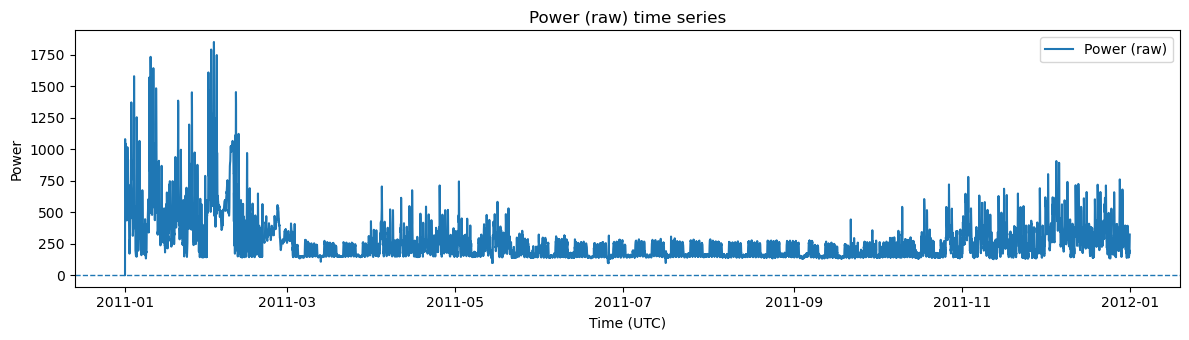

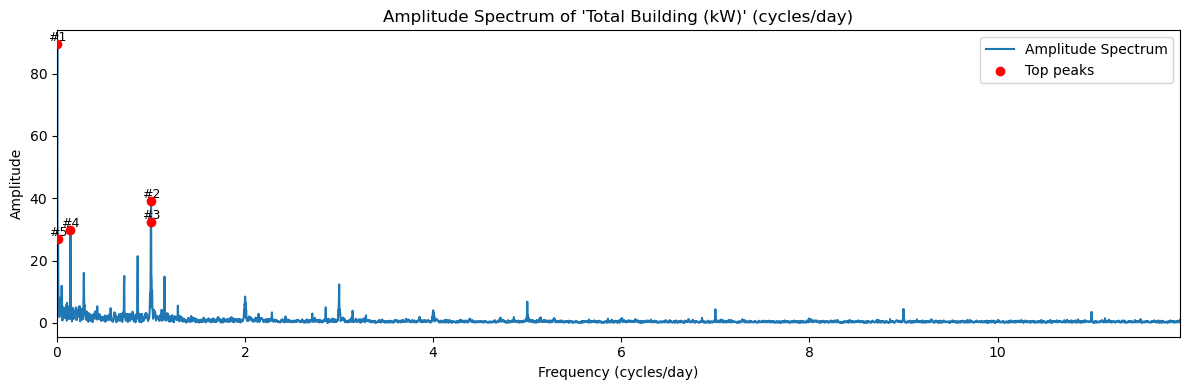

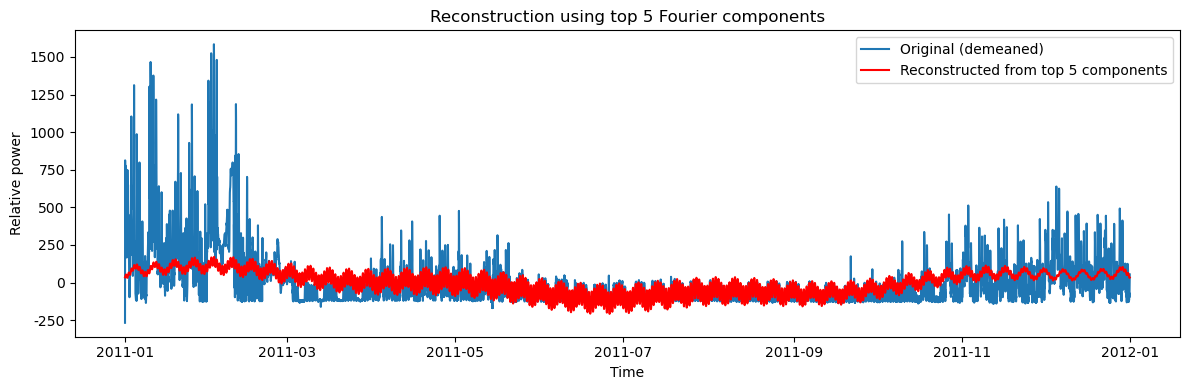

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# ==================== SETTINGS ====================
csv_path = Path("rsfmeasureddata2011.csv")   # Input CSV file
top_k = 5                                    # Number of dominant frequencies to analyze
resample_rule = "1H"                         # Sampling frequency (hourly)
# ==================================================

# 1) Read data — only the “Date and Time” and “Total Building (kW)” columns
df = pd.read_csv(
    csv_path,
    usecols=["Date and Time", "Total Building (kW)"],
    parse_dates=["Date and Time"],
    skipinitialspace=True,   # handle spaces after commas
    engine="python",         # more tolerant of trailing commas
    na_values=["", "NA", "N/A"]
)

# Rename columns for consistency
df = df.rename(columns={
    "Date and Time": "datetime_utc",
    "Total Building (kW)": "total"
})
df = df.set_index("datetime_utc").sort_index()

# Convert to numeric and resample hourly
s = pd.to_numeric(df["total"], errors="coerce").resample(resample_rule).mean().interpolate("time")

# Basic sanity check
if len(s) < 2:
    raise ValueError("Not enough data points for FFT analysis.")

# Calculate sampling interval in hours
dt_hours = (s.index[1] - s.index[0]).total_seconds() / 3600.0

# 2) Demean & apply Hann window
x = s.values.astype(float)
x = x - np.nanmean(x)
window = np.hanning(len(x))
xw = x * window

# 3) FFT
X = np.fft.rfft(xw)
window_correction = np.sum(window) / len(window)
X = X / (len(x) * window_correction)

freq_cph = np.fft.rfftfreq(len(x), d=dt_hours)
freq_cpd = freq_cph * 24.0  # convert to cycles per day
amplitude = np.abs(X)
phase = np.angle(X)
if len(amplitude) > 1:
    amplitude[1:-1] *= 2.0  # correct for single-sided amplitude spectrum

# 4) Select top_k frequencies (excluding DC) + amplitude normalization
mask = freq_cpd > 0
freq_pos = freq_cpd[mask]
amp_pos = amplitude[mask]
phase_pos = phase[mask]

if len(amp_pos) == 0:
    raise ValueError("No valid frequency components found (data may be constant or too short).")

# --- Normalization: relative to max amplitude over positive frequencies (excluding DC) ---
amp_pos_max = float(np.max(amp_pos)) if amp_pos.size > 0 else 0.0
if amp_pos_max > 0:
    amp_pos_norm = amp_pos / amp_pos_max
else:
    amp_pos_norm = np.zeros_like(amp_pos)

# Select Top-K by raw amplitude
idx = np.argsort(amp_pos)[::-1][:top_k]
dominant_freqs = freq_pos[idx]
dominant_amps = amp_pos[idx]
dominant_amps_norm = amp_pos_norm[idx]  # normalized amplitudes
dominant_phases = phase_pos[idx]
dominant_period_days = 1.0 / dominant_freqs
dominant_period_hours = dominant_period_days * 24.0

# 5) Display main results
print(f"Sampling interval: {dt_hours:.3f} hours/sample")
print(f"Top {top_k} dominant periods (with phase info):")
print("-----------------------------------------------------------")
for i, (f, a, a_norm, phi, pdays, phours) in enumerate(
    zip(dominant_freqs, dominant_amps, dominant_amps_norm,
        dominant_phases, dominant_period_days, dominant_period_hours), 1
):
    peak_fraction = (-phi / (2 * np.pi)) % 1.0
    peak_hours = peak_fraction * phours
    print(
        f"{i}. Frequency = {f:.4f} cycles/day, "
        f"Amplitude = {a:,.2f} (norm={a_norm:.4f}), "
        f"Period = {pdays:.3f} days ({phours:.1f} h), "
        f"Phase = {phi:.3f} rad, "
        f"Peak at {peak_fraction*100:.1f}% of cycle (~{peak_hours:.1f} h after start)"
    )

# === (5.1) Machine-readable JSON summary ===
results = {
    "resample_rule": str(resample_rule),
    "top_k": int(top_k),
    "n_samples": int(len(x)),
    "sampling_interval_hours": float(dt_hours),
    "time_start_utc": s.index[0].isoformat(),
    "time_end_utc": s.index[-1].isoformat(),
    # Normalization metadata for reproducibility
    "amplitude_normalization": {
        "method": "max_of_positive_frequencies",
        "reference_max_amplitude": float(amp_pos_max),
        "note": "amplitude_normalized = amplitude / max(amplitude over positive frequencies; DC excluded)"
    },
    "dominant_components": []
}

for f, a, a_norm, phi, pdays, phours in zip(
    dominant_freqs, dominant_amps, dominant_amps_norm, dominant_phases, dominant_period_days, dominant_period_hours
):
    peak_fraction = float((-phi / (2 * np.pi)) % 1.0)
    peak_hours = float(peak_fraction * phours)

    results["dominant_components"].append({
        "frequency_cycles_per_day": float(f),
        "amplitude": float(a),
        "amplitude_normalized": float(a_norm),
        "phase_rad": float(phi),
        # Uncomment below if you want to include peak position info:
        # "peak_fraction_of_cycle": peak_fraction,
        # "peak_after_hours_from_start": peak_hours,
    })

print("\n=== JSON summary ===")
print(json.dumps(results, ensure_ascii=False, indent=2))

# 6) Plot configuration
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

# ---- (A) Demeaned time series
plt.figure(figsize=(12, 3.5))
plt.plot(s.index, s.values, label="Power (raw)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Power (raw) time series")
plt.xlabel("Time (UTC)")
plt.ylabel("Power")
plt.legend()
plt.tight_layout()
plt.show()

# ---- (B) Amplitude spectrum
plt.figure(figsize=(12, 4))
plt.plot(freq_cpd, amplitude, label="Amplitude Spectrum")
plt.scatter(dominant_freqs, dominant_amps, color="red", zorder=5, label="Top peaks")
for i, f in enumerate(dominant_freqs):
    plt.text(f, dominant_amps[i], f"#{i+1}", fontsize=9, ha='center', va='bottom')
plt.xlim(0, np.percentile(freq_cpd, 99.5))
plt.title("Amplitude Spectrum of 'Total Building (kW)' (cycles/day)")
plt.xlabel("Frequency (cycles/day)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# ---- (C) Reconstruct dominant components (optional)
t = np.arange(len(x)) * dt_hours / 24.0  # time axis in days
reconstructed = np.zeros_like(x)
for f, A, phi in zip(dominant_freqs, dominant_amps, dominant_phases):
    reconstructed += A * np.cos(2 * np.pi * f * t + phi)

plt.figure(figsize=(12, 4))
plt.plot(s.index, x, label="Original (demeaned)")
plt.plot(s.index, reconstructed, label=f"Reconstructed from top {top_k} components", color="red")
plt.title(f"Reconstruction using top {top_k} Fourier components")
plt.xlabel("Time")
plt.ylabel("Relative power")
plt.legend()
plt.tight_layout()
plt.show()
